# SOGOS Overview for MLGeo 2022

Southern Ocean Glider Observations of the Submesoscale

Notes 2022.10.26
- Check project_overview.md in ml-geo git folder for additional comments
- Will add module with functions to our git folder soon! Trying to simplify so it's not so ugly to read

In [1]:
# Import packages 
import xarray as xr
import pandas as pd
import numpy as np
import gsw 
import matplotlib.pyplot as plt
from cmocean import cm as cmo
from datetime import datetime
import scipy
import glidertools as gt
import importlib

import sogos_module as sg  # our custom module
# from sogos_module import lims, palettes

In [2]:
# Import glider data
# Change this to your file path 
file_path = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS/gridded-vars/'

# Pressure-gridded data to 1m for each glider
gp_659 = xr.open_dataset(file_path + 'gp_659_forMLGeo1026.nc')
gp_660 = xr.open_dataset(file_path + 'gp_660_forMLGeo1026.nc')

# Isopycnal-gridded data (to .001 sigma) for each glider
gi_659 = xr.open_dataset(file_path + 'gi_659_forMLGeo1026.nc')
gi_660 = xr.open_dataset(file_path + 'gi_660_forMLGeo1026.nc')


- Note coordinates of the "gp" gridded-pressure Dataset:

                nprof: profile number for glider. 
                    Each upcast and downcast of the glider dive counts as a separate profile .
                    Dive number is stored separately as a variable

                depth: gridded to 1m, to 1000m depth

- Information on variables is in the file `Seaglider_DataGuide.pdf` in the main ml-sogos folder.
- Note two oxygen variables:

                'oxygen_raw' is uncorrected for the optode time response lag. 
                'oxygen' has been corrected using the method in Bittig (2017) and should be used
                

In [3]:
# Gridded onto pressure
gp_659

<xarray.Dataset>
Dimensions:     (depth: 1001, nprof: 912)
Coordinates:
  * nprof       (nprof) int64 0 1 2 3 4 5 6 7 ... 905 906 907 908 909 910 911
  * depth       (depth) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Data variables:
    time        (depth, nprof) datetime64[ns] ...
    dive        (nprof) int16 ...
    lat         (depth, nprof) float32 ...
    lon         (depth, nprof) float32 ...
    speed       (depth, nprof) float32 ...
    P           (depth, nprof) float32 ...
    SA          (depth, nprof) float32 ...
    CT          (depth, nprof) float32 ...
    oxygen_raw  (depth, nprof) float32 ...
    sigma       (depth, nprof) float64 ...
    days        (depth, nprof) float64 ...
    buoyancy    (depth, nprof) float64 ...
    oxygen      (depth, nprof) float64 ...
Attributes:
    id:                              sg659_level3
    time_coverage_resolution:        PT1S
    geospatial_vertical_units:       meter
    geospatial_vertical_resolution:  meter
    geospatial_vertical_positive:    no
    platform:                        glider
    geospatial_lat_units:            degrees
    geospatial_lat_resolution:       seconds
    geospatial_lon_units:            degrees
    geospatial_lon_resolution:       seconds
    institution:                     Applied Physics Lab, University of Washi...
    license:                         These data may be redistributed and used...
    keywords_vocabulary:             NASA/GCMD Earth Science Keywords Version...
    references:                      http://data.nodc.noaa.gov/accession/0092291
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Conventions:                     CF-1.6
    standard_name_vocabulary:        CF-1.6
    featureType:                     trajectoryProfile
    nodc_template_version:           NODC_NetCDF_Trajectory_Template_v0.9
    naming_authority:                edu.washington.apl
    creator_name:                    Luc Rainville
    creator_url:                     https://iop.apl.washington.edu
    creator_email:                   lucrain@uw.edu
    platform_id:                     SG659
    source:                          Seaglider SG659
    summary:                         SG659 SOGOS April 2019
    project:                         SOGOS April 2019
    glider:                          659
    mission:                         2
    seaglider_software_version:      66.12
    base_station_version:            3.0
    base_station_micro_version:      0
    quality_control_version:         1.12
    processing_level:                1.12
    instrument:                      aa4831 sbe41 wlbb2fl 
    title:                           Physical, chemical, and biological data ...
    keywords:                        Water Temperature, Conductivity, Salinit...
    geospatial_lon_min:              30.04640
    geospatial_lon_max:              67.79239
    geospatial_lat_min:              -53.45803
    geospatial_lat_max:              -45.64820
    time_coverage_start:             2019-04-30T13:58:31Z
    time_coverage_end:               2019-11-25T03:53:12Z
    time_coverage_duration:          P0000-00-208T13:54:40
    geospatial_vertical_min:         0.00
    geospatial_vertical_max:         1000.00
    date_created:                    2021-09-24T17:29:48Z
    date_modified:                   2021-09-24T17:29:48Z
    uuid:                            0440e19e-1d5d-11ec-9be7-acde48001122

In [4]:
# Gridded onto isopycnals
gi_659

<xarray.Dataset>
Dimensions:   (nprof: 912, sigma: 1001)
Coordinates:
  * sigma     (sigma) float64 26.8 26.8 26.8 26.8 26.8 ... 27.8 27.8 27.8 27.8
  * nprof     (nprof) int64 0 1 2 3 4 5 6 7 ... 904 905 906 907 908 909 910 911
Data variables:
    time      (sigma, nprof) datetime64[ns] ...
    days      (sigma, nprof) float64 ...
    lat       (sigma, nprof) float32 ...
    lon       (sigma, nprof) float32 ...
    dive      (nprof) int16 ...
    SA        (sigma, nprof) float64 ...
    CT        (sigma, nprof) float64 ...
    oxygen    (sigma, nprof) float64 ...
    P         (sigma, nprof) float64 ...
    buoyancy  (sigma, nprof) float64 ...
    AOU       (sigma, nprof) float64 ...

# Spice and Horizontal Spice Gradient Calculation

- We will need spice and horizontal spice gradient for each glider as our GMM clustering variables 
- Spice can be calculated with SA and CT using gsw
- Horizontal spice gradient needs to be calculated with our own function

In [6]:
# Adding spice as a glider variable using gsw 
def add_spice(gp_glider):
    spice = gsw.spiciness0(gp_glider['SA'], gp_glider['CT']) # referenced to surface 0 dbar
    gp_glider["spice"] = xr.DataArray(spice, dims = ["depth", "nprof"], 
                         coords = [gp_glider.depth.values, gp_glider.nprof.values] )
    return gp_glider

In [7]:
gp_659 = add_spice(gp_659)
gp_660 = add_spice(gp_660)

# need to modify fxn slightly to return in sigma dims
# gi_659 = add_spice(gi_659)
# gi_660 = add_spice(gi_660)

In [58]:
# Helpful plotting function as a quick check
# Better plotting functions will be in the module I upload soon!

def plot_var(gp_glider, var='SA'):
    fig = plt.figure(figsize=(8,4))
    ax = fig.gca()
    gp_glider[var].plot(ax=ax, cmap=cmo.dense)

    ax.margins(x=0.01)
    ax.invert_yaxis()
    ax.set_xlabel('profile number')

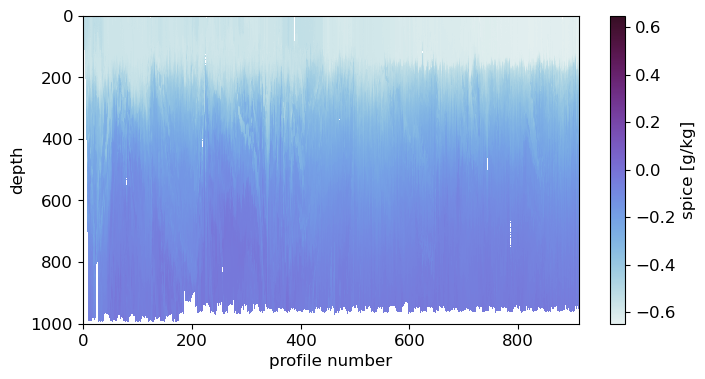

In [12]:
# Use module function to plot quick check
# sg.plot_var?

sg.plot_var(gp_659, 'spice')

Implementing horizontal gradient function:

                - For each pressure or density level, take pair of successive points as you increase nprof
                - Take difference between spice `d(Spice)`
                - Convert lat/lon of the points to a distance in m between the points `dx`
                - Return horizontal spice gradient as a Data Array with dimensions (depth, nprof)

In [21]:
# Adding horizontal gradient function
# def add_spice_gradient(gp):



